# Classification: margin

In this notebook, different margins around the face are used.

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
#export
from IPython.display import *
import cv2
from fastai.core import *
from fastai.vision import *
from facenet_pytorch import MTCNN
from kgl_deepfake.nb_00 import *
from kgl_deepfake.nb_01b import *
from kgl_deepfake.nb_03 import *

In [3]:
torch.multiprocessing.set_start_method('spawn')

In [4]:
from fastai.utils import show_install
show_install()



```text
=== Software === 
python        : 3.7.6
fastai        : 1.0.60
fastprogress  : 0.2.2
torch         : 1.4.0
nvidia driver : 418.87
torch cuda    : 10.1 / is available
torch cudnn   : 7603 / is enabled

=== Hardware === 
nvidia gpus   : 1
torch devices : 1
  - gpu0      : 16280MB | Tesla P100-PCIE-16GB

=== Environment === 
platform      : Linux-4.9.0-11-amd64-x86_64-with-debian-9.11
distro        : #1 SMP Debian 4.9.189-3+deb9u2 (2019-11-11)
conda env     : therealdeepfake
python        : /opt/anaconda3/envs/therealdeepfake/bin/python
sys.path      : /home/jupyter/kgl_deepfake/nbs
/opt/anaconda3/envs/therealdeepfake/lib/python37.zip
/opt/anaconda3/envs/therealdeepfake/lib/python3.7
/opt/anaconda3/envs/therealdeepfake/lib/python3.7/lib-dynload

/opt/anaconda3/envs/therealdeepfake/lib/python3.7/site-packages
/home/jupyter/fastai2
/home/jupyter/fastcore
/home/jupyter/nbdev
/home/jupyter/kgl_deepfake
/opt/anaconda3/envs/therealdeepfake/lib/python3.7/site-packages/IPython/extension

In [5]:
! nvidia-smi

Thu Feb  6 05:57:59 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.87.01    Driver Version: 418.87.01    CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    27W / 250W |     10MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

### Data

In [6]:
SOURCE = Path('../data/train_sample_videos/')

In [7]:
f = get_files(SOURCE, extensions=['.json'])[0]
annots = pd.read_json(f).T
annots.reset_index(inplace=True)
annots.rename({'index':'fname'}, axis=1, inplace=True)
annots.head()

fname label  split        original
0  aagfhgtpmv.mp4  FAKE  train  vudstovrck.mp4
1  aapnvogymq.mp4  FAKE  train  jdubbvfswz.mp4
2  abarnvbtwb.mp4  REAL  train            None
3  abofeumbvv.mp4  FAKE  train  atvmxvwyns.mp4
4  abqwwspghj.mp4  FAKE  train  qzimuostzz.mp4

In [8]:
annots.shape

(400, 4)

In [14]:
mtcnn_defaults = dict(device='cuda:0' if torch.cuda.is_available() else 'cpu',
                      post_process=False, select_largest=False)
mtcnn_defaults

{'device': 'cuda:0', 'post_process': False, 'select_largest': False}

In [23]:
def get_data(bs=32, sz=224, margin=0, resize=.5):
    detector = MTCNN(margin=margin, **mtcnn_defaults)
    src = (VideoFaceList
           .from_df(df=annots, path=SOURCE, cols='fname', 
                    detector=detector, resize=resize, equalize=True)
           .split_by_rand_pct())
    data = (src.label_from_df('label')
            .transform(get_transforms(), size=sz)
            .databunch(bs=bs, num_workers=4)
            .normalize(imagenet_stats))
    return data

### `margin=50`

In [9]:
margin = 50

In [24]:
%%time
data = get_data(margin=margin)
model = MesoNet()

CPU times: user 1min, sys: 1.26 s, total: 1min 1s
Wall time: 11.3 s


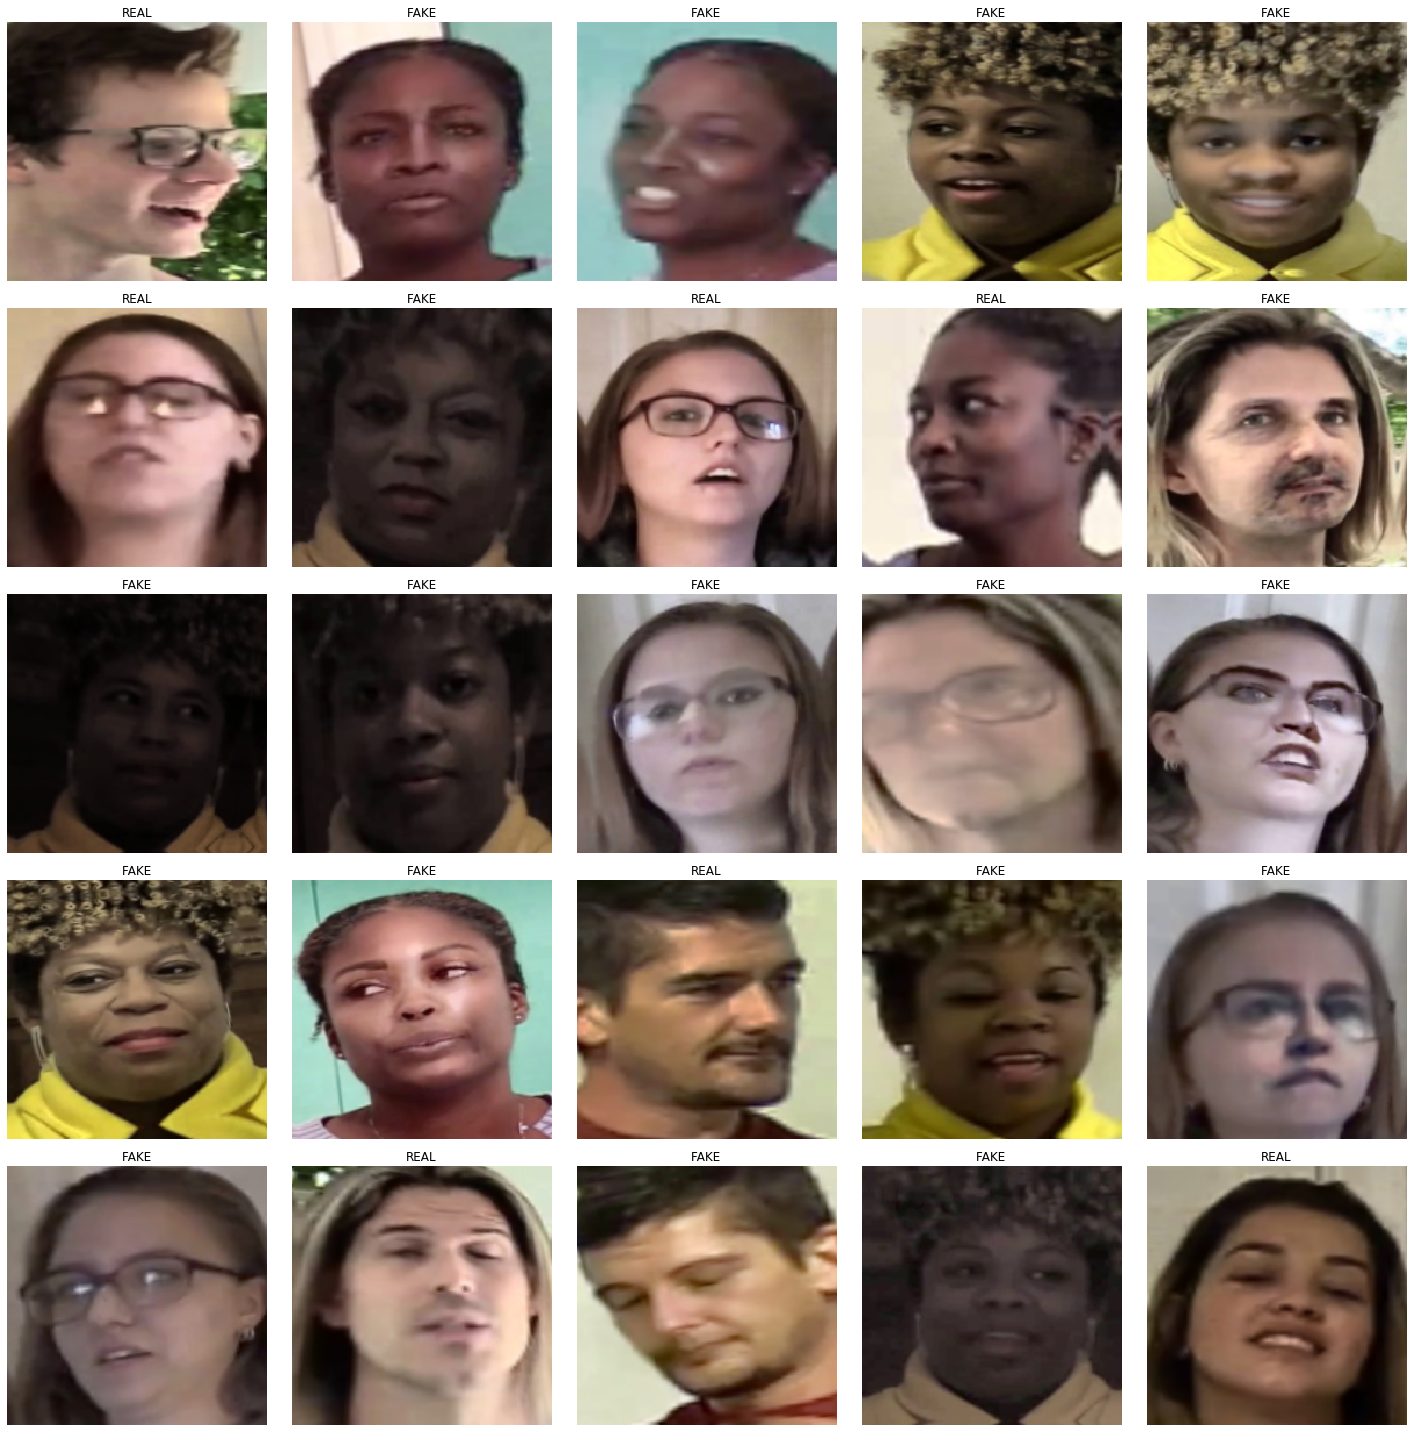

In [25]:
data.show_batch()

In [27]:
learn = Learner(data, model, metrics=accuracy).to_fp16()

In [28]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


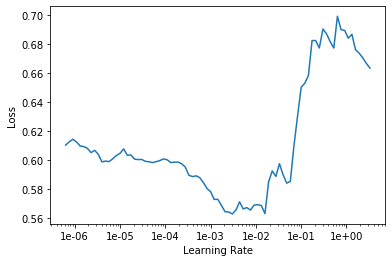

In [29]:
learn.recorder.plot()

In [30]:
learn.fit_one_cycle(cyc_len=10, max_lr=1e-3)

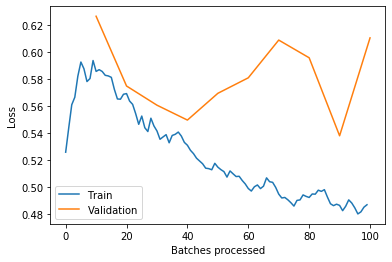

In [31]:
learn.recorder.plot_losses()

In [32]:
learn.save(f'mesonet_margin{margin}_resize0.5_equalizeTrue')

In [33]:
learn.load(f'mesonet_margin{margin}_resize0.5_equalizeTrue');

In [34]:
interp = ClassificationInterpretation.from_learner(learn)

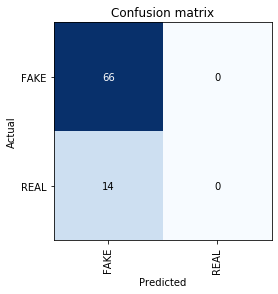

In [77]:
interp.plot_confusion_matrix()

### `margin = 25`

In [35]:
margin = 25

In [44]:
data = get_data(margin=margin)
model = MesoNet()

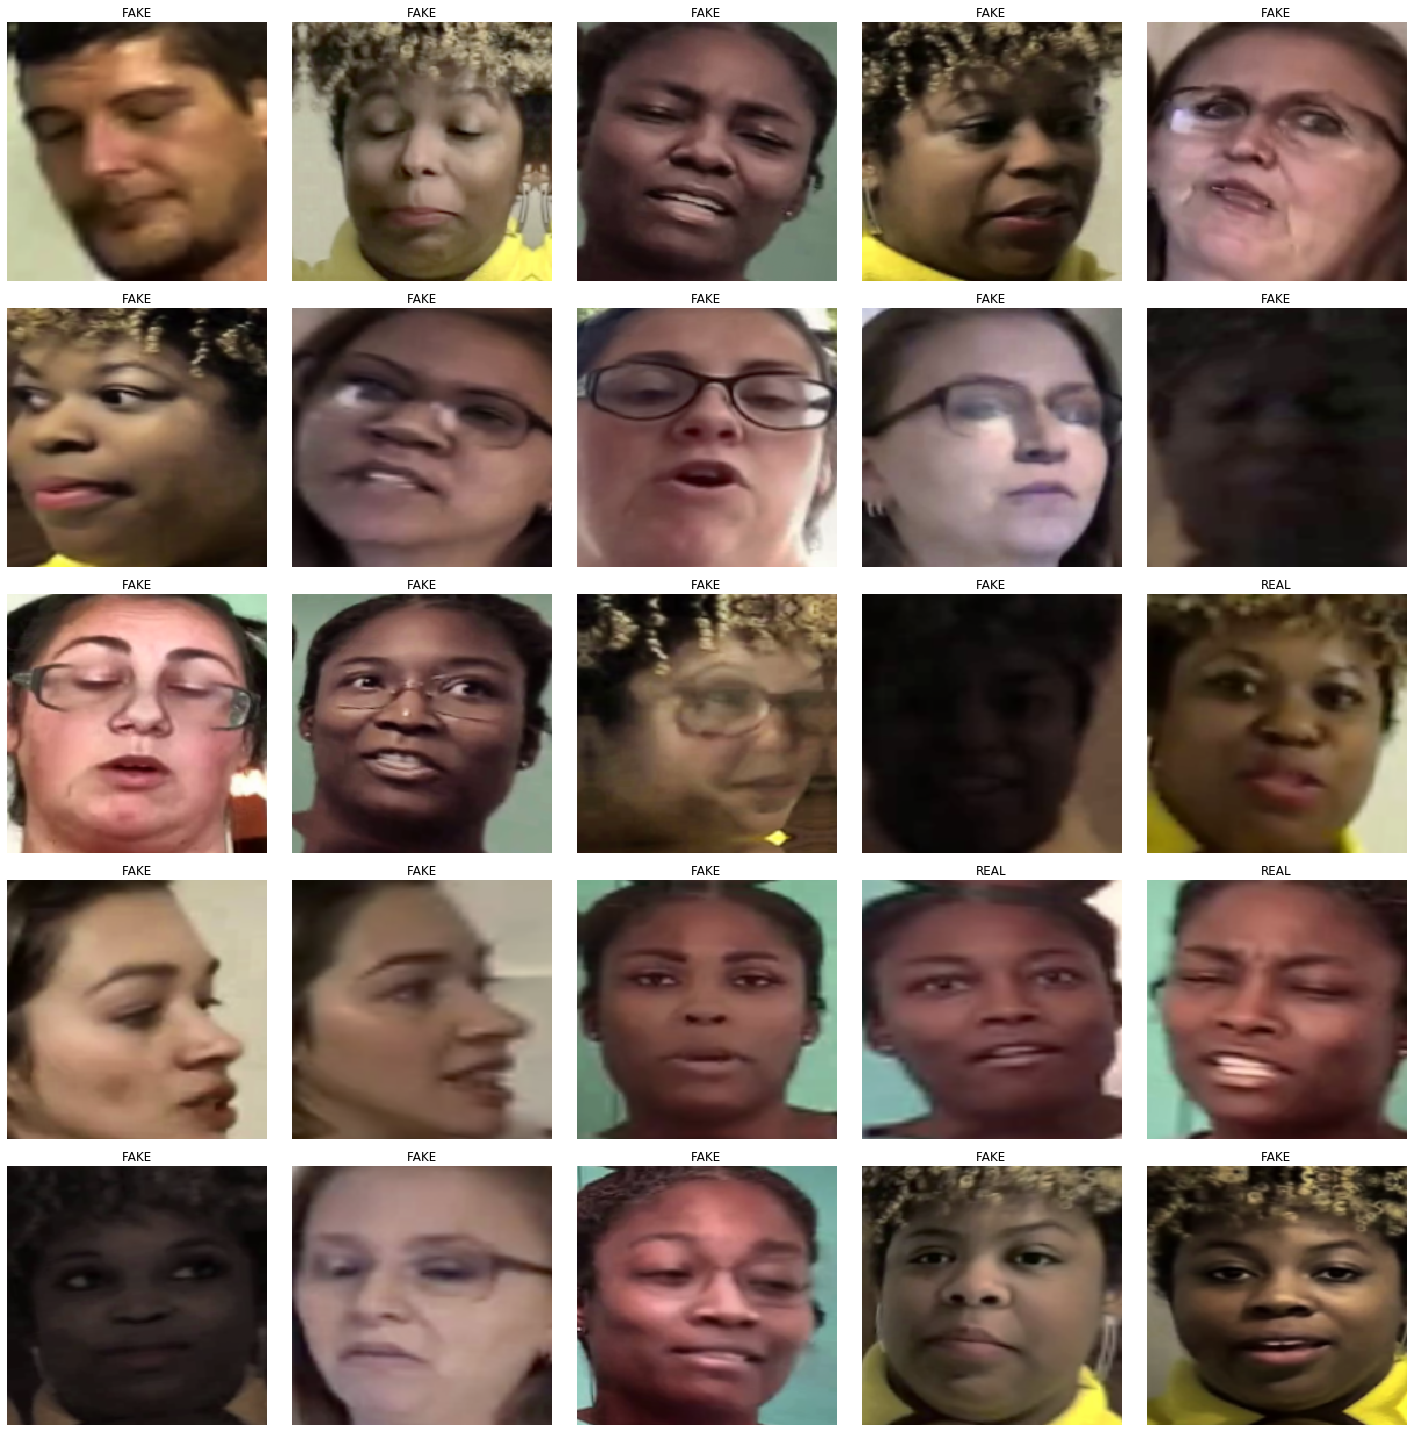

In [45]:
data.show_batch()

In [46]:
learn = Learner(data, model, metrics=accuracy).to_fp16()

In [47]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


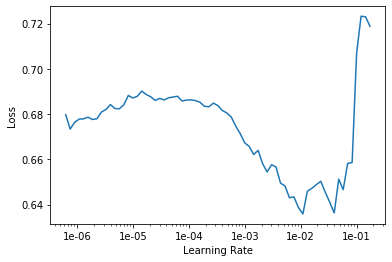

In [48]:
learn.recorder.plot()

In [49]:
learn.fit_one_cycle(cyc_len=10, max_lr=1e-3)

In [50]:
learn.save(f'mesonet_margin{margin}_resize0.5_equalizeTrue');

In [51]:
learn.load(f'mesonet_margin{margin}_resize0.5_equalizeTrue');

In [52]:
interp = ClassificationInterpretation.from_learner(learn)

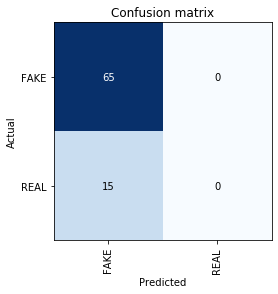

In [53]:
interp.plot_confusion_matrix()

# - fin

In [ ]:
from nbdev.export import *
notebook2script()